In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
from torch_geometric.loader import DataLoader
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
%matplotlib notebook
import copy

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

from joblib import Parallel, delayed

from cutlass import *
from rbfConv import *
from tqdm.notebook import tqdm

from datautils import *
# from sphUtils import *
from lossFunctions import *

In [2]:

from plotting import *
plt.style.use('dark_background')
# plt.style.use('default')
from tqdm.notebook import trange, tqdm

In [3]:
from datautils import *

In [5]:
basePath = '~/servus05/dev/datasets/generative2D_v1/train'
basePath = os.path.expanduser(basePath)

simulationFiles = [basePath + '/' + f for f in os.listdir(basePath) if f.endswith('.hdf5')]
debugPrint(simulationFiles)

simulationFiles [list] = ['/home/winchenbach/servus05/dev/datasets/generative2D_v1/train/generative - 2023-03-13_10-23-46.hdf5', '/home/winchenbach/servus05/dev/datasets/generative2D_v1/train/generative - 2023-03-13_10-08-20.hdf5', '/home/winchenbach/servus05/dev/datasets/generative2D_v1/train/generative - 2023-03-13_10-03-31.hdf5', '/home/winchenbach/servus05/dev/datasets/generative2D_v1/train/generative - 2023-03-13_10-18-34.hdf5', '/home/winchenbach/servus05/dev/datasets/generative2D_v1/train/generative - 2023-03-13_10-39-18.hdf5', '/home/winchenbach/servus05/dev/datasets/generative2D_v1/train/generative - 2023-03-13_10-28-47.hdf5', '/home/winchenbach/servus05/dev/datasets/generative2D_v1/train/generative - 2023-03-13_10-21-09.hdf5', '/home/winchenbach/servus05/dev/datasets/generative2D_v1/train/generative - 2023-03-13_10-05-55.hdf5', '/home/winchenbach/servus05/dev/datasets/generative2D_v1/train/generative - 2023-03-13_10-13-30.hdf5', '/home/winchenbach/servus05/dev/datasets/genera

<IPython.core.display.Javascript object>


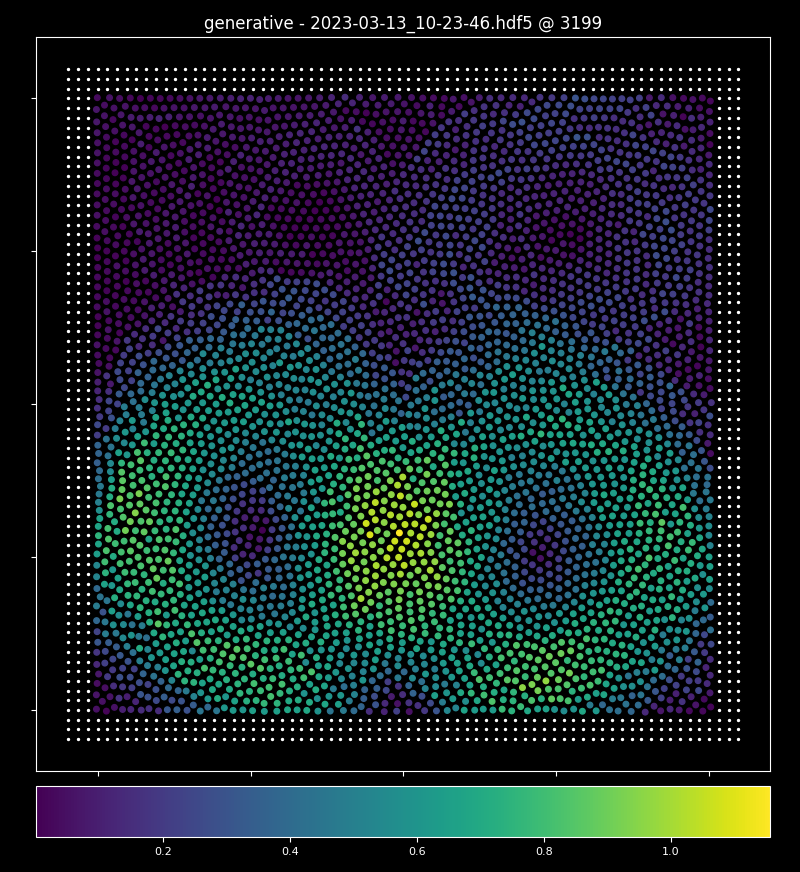

interactive(children=(Dropdown(description='file', options=('/home/winchenbach/servus05/dev/datasets/generativ…

<function __main__.plotNetwork(file, frame)>

In [40]:

fig, axis = plt.subplots(1, 1, figsize=(8,8*1.09), sharex = False, sharey = False, squeeze = False)

attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 0, 1 + np.arange(1), 1)


x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()

# v = (gt[:,-1:] - modelOutput) ** 2
v = torch.linalg.norm(inputData['fluidVelocity'],dim=1)

axis[0,0].set_title('Velocity')
# sc = axis[1,0].scatter(x,y,c = v,s=0.25)
GTsc = axis[0,0].scatter(x,y,c = v.detach().cpu().numpy(), s= 16)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-1.2,1.2)
axis[0,0].set_ylim(-1.2,1.2)
# axis[0,1].axvline(-2)
# axis[0,1].axvline(2)
# axis[0,1].axhline(-2)
# axis[0,1].axhline(2)
axis[0,0].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =2 )
axis[0,0].set_xticklabels([])
axis[0,0].set_yticklabels([])
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='horizontal')
GTcbar.ax.tick_params(labelsize=8) 
fig.tight_layout()


def plotNetwork(file, frame):
    attributes, inputData, groundTruthData = loadFrame(file, frame, 0 + np.arange(1), 1)

    data = inputData['fluidDensity'].detach().cpu().numpy()
    positions = inputData['fluidPosition'].detach().cpu().numpy()
    
    data = torch.linalg.norm(inputData['fluidVelocity'],dim=1).detach().cpu().numpy()
#     debugPrint(data.shape)
    positions = inputData['fluidPosition'].detach().cpu().numpy()
    GTsc.set_offsets(positions)
    GTsc.set_array(data)
    GTcbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))

    axis[0,0].set_title('%s @ %2d' % (file.split('/')[-1], frame))
    fig.canvas.draw()
    fig.canvas.flush_events()



# plotNetwork(simulationFiles[0], 0, subfolders[0], epochs - 1)

interact(plotNetwork, file = simulationFiles, frame = widgets.IntSlider(value=0, min=0, max=3200 -1, step=1))



In [6]:
from tqdm.notebook import tqdm

In [8]:
# trainFolder = '/mnt/c/Users/Rimuru/trainingData'
trainFolder = '~/trainingdata_2D_deltaSPH_001'
trainFolder = '~/servus05/dev/torchSPH2/Cconv/trainingData'
trainFolder = '~/servus03/torchSPH2/Cconv/trainingData'
# trainFolder = '~/servus05/dev/torchSPH2/Cconv/trainingDataSeedVariance'
# trainFolder = '~/servus05/dev/torchSPH2/Cconv/trainingDataLongEpoch'
trainFolder = os.path.expanduser(trainFolder)
subfolders = [ f.path for f in os.scandir(trainFolder) if f.is_dir() ]
# subfolders = [ f.path for f in os.scandir('./trainingDataBasisFunctions8x8') if f.is_dir() ]
print(len(subfolders))

subfolders = [s for s in subfolders if os.path.exists(s + '/results.json')]
print(len(subfolders))

dataDict = {}

# subfolders = [subfolders[0]]
for s in tqdm(subfolders):
    with open("%s/results.json" % s, "r") as read_file:
        decodedArray = json.load(read_file)
        dataDict[s] = decodedArray
#         print(decodedArray['hyperParameters'])   

66
66


  0%|          | 0/66 [00:00<?, ?it/s]

In [9]:

from rbfConv import *
from datautils import *
from rbfNet import *

In [10]:


def loadRbfModel(file, frame, networkPath, epoch):
    with open(os.path.expanduser("%s/results.json" % networkPath), "r") as read_file:
        decodedArray = json.load(read_file)
        dataDict = decodedArray
    
    n = dataDict['hyperParameters']['n']
    m = dataDict['hyperParameters']['m']
    coordinateMapping = dataDict['hyperParameters']['coordinateMapping']
    windowFn = getWindowFunction(dataDict['hyperParameters']['windowFunction'])
    rbf_x = dataDict['hyperParameters']['rbf_x']
    rbf_y = dataDict['hyperParameters']['rbf_y']
    dist = dataDict['hyperParameters']['frameDistance']
    unroll = dataDict['hyperParameters']['maxRollOut']
    arch = [32, 64, 64, 2]
    arch = [16, 32, 32, 2]
    arch = dataDict['hyperParameters']['arch']
    arch = [int(a) for a in arch.split(' ') if a != '']
    epochs = dataDict['hyperParameters']['epochs']
#     print(arch)
#     print(n, m)
#     print(dataDict['hyperParameters']['windowFunction'])
#     print(rbf_x)
#     print(rbf_y)

    attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(unroll), dist)
    inputData['fluidGravity'] = inputData['fluidGravity'][:,:2]
    
    
    fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)
#     print(fluidFeatures.shape)
#     print(boundaryFeatures.shape)
    if 'network' not in dataDict['hyperParameters']:
        model = RbfNet(fluidFeatures.shape[1],boundaryFeatures.shape[1], layers = arch, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = 32, )
    else:
        network = dataDict['hyperParameters']['network']
        model = None
        if network == 'default':
            model = RbfNet(fluidFeatures.shape[1],boundaryFeatures.shape[1], layers = arch, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = 32, )
        if network == 'split':
            model = RbfSplitNet(fluidFeatures.shape[1],boundaryFeatures.shape[1], layers = arch, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = 32, )
        if network == 'interleaved':
            model = RbfInterleaveNet(fluidFeatures.shape[1],boundaryFeatures.shape[1], layers = arch, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = 32, )
        if network == 'input':
            model = RbfInputNet(fluidFeatures.shape[1],boundaryFeatures.shape[1], layers = arch, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = 32, )
        if network == 'output':
            model = RbfOutputNet(fluidFeatures.shape[1],boundaryFeatures.shape[1], layers = arch, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = 32, )


    model.load_state_dict(torch.load(os.path.expanduser('%s/model_%03d.torch' % (networkPath, epoch if epoch >= 0 else epochs - 1))))
    model = model.to(device)
    model.train(False)
    return model, dataDict['hyperParameters']

In [11]:
from tqdm.notebook import tqdm

In [12]:

@torch.jit.script
def wendland(q, h):
    C = 7 / np.pi
    b1 = torch.pow(1. - q, 4)
    b2 = 1.0 + 4.0 * q
    return b1 * b2 * C / h**2    
@torch.jit.script
def wendlandGrad(q,r,h):
    C = 7 / np.pi    
    return - r * C / h**3 * (20. * q * (1. -q)**3)[:,None]
    

In [13]:
def getParticleQuantities(positions, bPositions, area, boundaryArea, attributes):
    # bPositions = boundaryPositions.to(device)
    # area = inputData['fluidArea'].to(device)
    # boundaryArea = inputData['boundaryArea'].to(device)

    fi, fj = radius(positions, positions, attributes['support'], max_num_neighbors = 256, batch_x = None, batch_y = None)
    bf, bb = radius(bPositions, positions, attributes['support'], max_num_neighbors = 256, batch_x = None, batch_y = None)
    bi, bj = radius(bPositions, bPositions, attributes['support'], max_num_neighbors = 256, batch_x = None, batch_y = None)

    i, ni = torch.unique(fi, return_counts = True)
    b, nb = torch.unique(bf, return_counts = True)

    fluidNeighbors = torch.stack([fi, fj], dim = 0)
    fluidDistances = (positions[fi] - positions[fj])
    fluidRadialDistances = torch.linalg.norm(fluidDistances,axis=1)
    fluidDistances[fluidRadialDistances < 1e-5,:] = 0
    fluidDistances[fluidRadialDistances >= 1e-5,:] /= fluidRadialDistances[fluidRadialDistances >= 1e-5,None]
    fluidRadialDistances /= attributes['support']

    boundaryNeighbors = torch.stack([bf, bb], dim = 0)
    boundaryDistances = (positions[bf] - bPositions[bb])
    boundaryRadialDistances = torch.linalg.norm(boundaryDistances,axis=1)
    boundaryDistances[boundaryRadialDistances < 1e-5,:] = 0
    boundaryDistances[boundaryRadialDistances >= 1e-5,:] /= boundaryRadialDistances[boundaryRadialDistances >= 1e-5,None]
    boundaryRadialDistances /= attributes['support']

    boundaryBoundaryNeighbors = torch.stack([bi, bj], dim = 0)
    boundaryBoundaryDistances = (bPositions[bi] - bPositions[bj])
    boundaryBoundaryRadialDistances = torch.linalg.norm(boundaryBoundaryDistances,axis=1)
    boundaryBoundaryDistances[boundaryBoundaryRadialDistances < 1e-5,:] = 0
    boundaryBoundaryDistances[boundaryBoundaryRadialDistances >= 1e-5,:] /= boundaryBoundaryRadialDistances[boundaryBoundaryRadialDistances >= 1e-5,None]
    boundaryBoundaryRadialDistances /= attributes['support']
    density = scatter(area[fj] * wendland(fluidRadialDistances, attributes['support']), fi, dim=0, dim_size = positions.shape[0], reduce='add') + \
        scatter(boundaryArea[bb] * wendland(boundaryRadialDistances, attributes['support']), bf, dim=0, dim_size = positions.shape[0], reduce='add')
#     densityLoss = (density - groundTruths[0][:,4].to(device))**2

    boundaryDensity = scatter(area[bf] * wendland(boundaryRadialDistances, attributes['support']), bb, dim=0, dim_size = bPositions.shape[0], reduce='add') + \
            scatter(boundaryArea[bj] * wendland(boundaryBoundaryRadialDistances, attributes['support']), bi, dim=0, dim_size = bPositions.shape[0], reduce='add')
    # print(boundaryDensity)
    colorField = scatter(area[fj]/density[fj] * wendland(fluidRadialDistances, attributes['support']), fi, dim=0, dim_size = positions.shape[0], reduce='add') + \
        scatter(boundaryArea[bb]/boundaryDensity[bb] * wendland(boundaryRadialDistances, attributes['support']), bf, dim=0, dim_size = positions.shape[0], reduce='add')
    boundaryColorField = scatter(area[bf]/density[bf] * wendland(boundaryRadialDistances, attributes['support']), bb, dim=0, dim_size = bPositions.shape[0], reduce='add') + \
        scatter(boundaryArea[bi]/boundaryDensity[bi] * wendland(boundaryBoundaryRadialDistances, attributes['support']), bj, dim=0, dim_size = bPositions.shape[0], reduce='add')

    fluidGrad = wendlandGrad(fluidRadialDistances, fluidDistances, attributes['support'])
    boundaryGrad = wendlandGrad(boundaryRadialDistances, boundaryDistances, attributes['support'])
    colorGrad = scatter((area[fj]/density[fj] * (colorField[fj] - colorField[fi]))[:,None] * fluidGrad, fi, dim=0, dim_size = positions.shape[0], reduce='add') + \
            scatter((boundaryArea[bb]/boundaryDensity[bb] * (boundaryColorField[bb] - colorField[bf]))[:,None] * boundaryGrad, bf, dim=0, dim_size = positions.shape[0], reduce='add')

    return density, colorField, colorGrad

In [14]:
def scatterPlot(ax, positions, data, boundaryPositions, title = None):
    ax.axis('equal')
    im = ax.scatter(positions[:,0].detach().cpu().numpy(), positions[:,1].detach().cpu().numpy(), c = data.detach().cpu().numpy(), s = 2)    
    ax.scatter(boundaryPositions[:,0].detach().cpu().numpy(), boundaryPositions[:,1].detach().cpu().numpy(), s=2,c='white',alpha=0.5)
    ax.set_xlim(-1.2,1.2)
    ax.set_ylim(-1.2,1.2)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax1_divider = make_axes_locatable(ax)
    cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
    GTcbar = fig.colorbar(im, cax=cax1,orientation='horizontal')
    GTcbar.ax.tick_params(labelsize=8) 
    if title is not None:
        ax.set_title(title)
    return im, GTcbar

In [15]:
def getMeshQuantities(xFluid, bPositions, area, boundaryArea, density, velocity, attributes, n = 512, supportScale = 1):
    x = torch.linspace(-1,1,n, device = xFluid.device, dtype = xFluid.dtype)
    y = torch.linspace(-1,1,n, device = xFluid.device, dtype = xFluid.dtype)
    xx,yy = torch.meshgrid(x,y, indexing='xy')

    xxf = xx.flatten()
    yyf = yy.flatten()
    positions = torch.vstack((xxf, yyf)).mT
    z = yyf
    # z = torch.linalg.norm(positions,dim=1).reshape(xx.shape)
#     bPositions = boundaryPositions.to(device)
#     area = inputData['fluidArea'].to(device)
#     boundaryArea = inputData['boundaryArea'].to(device)

    xm, xf = radius(xFluid, positions, attributes['support'] * supportScale, max_num_neighbors = 256, batch_x = None, batch_y = None)


    # fluidNeighbors = torch.stack([xf, xm], dim = 0)
    fluidDistances = (positions[xm] - xFluid[xf])
    fluidRadialDistances = torch.linalg.norm(fluidDistances,axis=1)
    fluidDistances[fluidRadialDistances < 1e-5,:] = 0
    fluidDistances[fluidRadialDistances >= 1e-5,:] /= fluidRadialDistances[fluidRadialDistances >= 1e-5,None]
    fluidRadialDistances /= attributes['support'] * supportScale


    bm, bb = radius(bPositions, positions, attributes['support'] * supportScale, max_num_neighbors = 256, batch_x = None, batch_y = None)


    # fluidNeighbors = torch.stack([xf, xm], dim = 0)
    boundaryDistances = (positions[bm] - bPositions[bb])
    boundaryRadialDistances = torch.linalg.norm(boundaryDistances,axis=1)
    boundaryDistances[boundaryRadialDistances < 1e-5,:] = 0
    boundaryDistances[boundaryRadialDistances >= 1e-5,:] /= boundaryRadialDistances[boundaryRadialDistances >= 1e-5,None]
    boundaryRadialDistances /= attributes['support'] * supportScale
    
    meshDensity = scatter(area[xf] * wendland(fluidRadialDistances, attributes['support'] * supportScale), xm, dim=0, dim_size = positions.shape[0], reduce = 'add') + \
    scatter(boundaryArea[bb] * wendland(boundaryRadialDistances, attributes['support'] * supportScale), bm, dim=0, dim_size = positions.shape[0], reduce = 'add')
    
    meshVelocity = scatter((area[xf] / density[xf] * wendland(fluidRadialDistances, attributes['support'] * supportScale))[:,None] * velocity[xf], xm, dim=0, dim_size = positions.shape[0], reduce = 'add')

    meshDivergence = scatter(area[xf] / density[xf] * torch.einsum('nd, nd -> n', (wendlandGrad(fluidRadialDistances, fluidDistances, attributes['support'] * supportScale)), velocity[xf] - meshVelocity[xm]), xm, dim=0, dim_size = positions.shape[0], reduce = 'add')
    
    return positions.reshape((xx.shape[0],xx.shape[1],2)), meshDensity.reshape((xx.shape[0],xx.shape[1])), meshVelocity.reshape((xx.shape[0],xx.shape[1],2)), meshDivergence.reshape((xx.shape[0],xx.shape[1]))

def plotMeshData(fp, meshDensity, gtMeshDensity, meshVelocity, gtMeshVelocity, meshDivergence, gtMeshDivergence):
    fig, axis = plt.subplots(3, 5, figsize=(16,12), sharex = False, sharey = False, squeeze = False)
    meshPlot(axis[0,0], fp, meshDensity, 'Pred Density')
    meshPlot(axis[0,1], fp, meshVelocity[:,:,0], 'Pred Velocity.x')
    meshPlot(axis[0,2], fp, meshVelocity[:,:,1], 'Pred Velocity.y')
    meshPlot(axis[0,3], fp, torch.linalg.norm(meshVelocity, dim=2), '|Pred Velocity|')
    meshPlot(axis[0,4], fp, meshDivergence, 'Pred Divergence')

    meshPlot(axis[1,0], fp, gtMeshDensity, 'GT Density')
    meshPlot(axis[1,1], fp, gtMeshVelocity[:,:,0], 'GT Velocity.x')
    meshPlot(axis[1,2], fp, gtMeshVelocity[:,:,1], 'GT Velocity.y')
    meshPlot(axis[1,3], fp, torch.linalg.norm(gtMeshVelocity, dim=2), '|GT Velocity|')
    meshPlot(axis[1,4], fp, gtMeshDivergence, 'GT Divergence')

    meshPlot(axis[2,0], fp, meshDensity - gtMeshDensity, 'Diff Density')
    meshPlot(axis[2,1], fp, meshVelocity[:,:,0] - gtMeshVelocity[:,:,0], 'Diff Velocity.x')
    meshPlot(axis[2,2], fp, meshVelocity[:,:,1] - gtMeshVelocity[:,:,1], 'Diff Velocity.y')
    meshPlot(axis[2,3], fp, torch.linalg.norm(meshVelocity - gtMeshVelocity, dim=2), '|Diff Velocity|')
    meshPlot(axis[2,4], fp, meshDivergence - gtMeshDivergence, 'Diff Divergence')

    fig.tight_layout()
    

def meshPlot(ax, positions, data, title = None):
    ax.axis('equal')
#     print(positions[:,:,0].flatten().shape)
#     print(data.shape)
    im = ax.pcolormesh(positions[:,:,0].detach().cpu().numpy(), positions[:,:,1].detach().cpu().numpy(), data.detach().cpu().numpy())    
#     ax.scatter(boundaryPositions[:,0], boundaryPositions[:,1], s=1,c='white',alpha=0.5)
    ax.set_xlim(-1.,1.)
    ax.set_ylim(-1.,1.)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax1_divider = make_axes_locatable(ax)
    cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
    GTcbar = fig.colorbar(im, cax=cax1,orientation='horizontal')
    GTcbar.ax.tick_params(labelsize=8) 
    if title is not None:
        ax.set_title(title)
    return im, GTcbar

In [16]:
def analyzeParticles(positions, gtPositions, boundaryPositions, velocities, gtVelocities, fluidArea, boundaryArea, attributes):    
    positionLoss = torch.linalg.norm(positions - gtPositions.to(device), dim=1)
    velocityLoss = torch.linalg.norm(velocities - gtVelocities.to(device), dim=1)
    density, colorField, colorGrad = getParticleQuantities(positions, boundaryPositions, fluidArea, boundaryArea, attributes)
    
    gTPositionLoss = torch.linalg.norm(gtPositions - gtPositions, dim=1)
    gtVelocityLoss = torch.linalg.norm(gtVelocities - gtVelocities, dim=1)
    gtDensity2, gtColorField, gtColorGrad = getParticleQuantities(gtPositions, boundaryPositions, fluidArea, boundaryArea, attributes)
    
    return positionLoss, velocityLoss, density, gtDensity2, colorField, gtColorField, colorGrad, gtColorGrad
    

In [17]:
def particleAnalysis(positions, gtPositions, boundaryPositions, velocities, gtVelocities, fluidArea, boundaryArea, attributes, plot = True):
    positionLoss, velocityLoss, density, gtDensity, colorField, gtColorField, colorGrad, gtColorGrad = analyzeParticles(positions, gtPositions, boundaryPositions, velocities, gtVelocities, fluidArea, boundaryArea, attributes)
    if plot:
        fig, axis = plt.subplots(3, 6, figsize=(12,8*1.09), sharex = False, sharey = False, squeeze = False)

        scatterPlot(axis[0,0], positions, positionLoss, boundaryPositions, 'Position Loss')
        scatterPlot(axis[0,1], positions, velocityLoss, boundaryPositions, 'Velocity Loss')
        scatterPlot(axis[0,2], positions, density, boundaryPositions, 'Density')
        scatterPlot(axis[0,3], positions, colorField, boundaryPositions, 'Color')
        scatterPlot(axis[0,4], positions, colorGrad[:,0], boundaryPositions, 'Grad.x Color')
        scatterPlot(axis[0,5], positions, colorGrad[:,1], boundaryPositions, 'Grad.y Color')

        scatterPlot(axis[1,0], gtPositions, torch.zeros_like(density), boundaryPositions, 'GT Position Loss')
        scatterPlot(axis[1,1], gtPositions, torch.zeros_like(density), boundaryPositions, 'GT Velocity Loss')
        scatterPlot(axis[1,2], gtPositions, gtDensity, boundaryPositions, 'GT Density')
        scatterPlot(axis[1,3], gtPositions, gtColorField, boundaryPositions, 'GT Color')
        scatterPlot(axis[1,4], gtPositions, gtColorGrad[:,0], boundaryPositions, 'GT Grad.x Color')
        scatterPlot(axis[1,5], gtPositions, gtColorGrad[:,1], boundaryPositions, 'GT Grad.y Color')

        scatterPlot(axis[2,0], gtPositions, positionLoss, boundaryPositions, 'Position Loss')
        scatterPlot(axis[2,1], gtPositions, velocityLoss, boundaryPositions, 'Velocity Loss')
        scatterPlot(axis[2,2], gtPositions, density - gtDensity, boundaryPositions, 'Diff Density')
        scatterPlot(axis[2,3], gtPositions, colorField - gtColorField, boundaryPositions, 'Diff Color')
        scatterPlot(axis[2,4], gtPositions, colorGrad[:,0] - gtColorGrad[:,0], boundaryPositions, 'Diff Grad.x Color')
        scatterPlot(axis[2,5], gtPositions, colorGrad[:,1] - gtColorGrad[:,1], boundaryPositions, 'Diff Grad.y Color')

        fig.tight_layout()
    return positionLoss, velocityLoss, density, gtDensity, colorField, gtColorField, colorGrad, gtColorGrad

In [18]:
import scipy.stats as stats

def getPSD(data):
    image = data.detach().cpu().numpy()
    npix = image.shape[0]
    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)**2
    kfreq = np.fft.fftfreq(npix) * npix

    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()
    kbins = np.arange(0.01, npix//(2*np.pi)+1, 0.5)
    kbins = np.arange(0.5, npix//2+1, 1.)

    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                         statistic = "mean",
                                         bins = kbins)

    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    return kvals, Abins

def analyzeMesh(data, filterLevels = 0):
# data = torch.linalg.norm(meshVelocity,dim=1).reshape(xx.shape)
    if filterLevels > 0 :
        filtered = scipy.ndimage.gaussian_filter(data.detach().cpu().numpy(),filterLevels)
        filtered = torch.tensor(filtered, device = data.device, dtype = data.dtype)
    else:
        filtered = data
    # data = torch.linalg.norm(meshVelocity,dim=1)
    fft = torch.fft.fftshift(torch.fft.fft2(filtered))
    # fft = torch.fft.fft2(torch.linalg.norm(meshVelocity,dim=1).reshape(xx.shape))
    fftfreq = torch.fft.fftshift(torch.fft.fftfreq(filtered.shape[0],2 / filtered.shape[0]))
    # fftfreq = (torch.fft.fftfreq(xx.shape[0],2 / xx.shape[0]))
    fx, ft = torch.meshgrid(fftfreq, fftfreq, indexing = 'xy')
    # print(fx.shape)
    # print(ft.shape)
    fp = torch.vstack((fx.flatten(),ft.flatten())).mT

    return fp, fft, getPSD(filtered), filtered

In [19]:
def meshAnalysis(positions, data, gtData,plot = True, linThresh = 1e-2, linScale = 1):
    fp, fft, psd, filtered = analyzeMesh(data)
    fp, gtFft, gtPsd, gtFiltered = analyzeMesh(gtData)
    if plot:
        fig, axis = plt.subplots(3, 4, figsize=(16,11*1.09), sharex = False, sharey = False, squeeze = False)
        meshPlot(axis[0,0], positions, data, 'Original Prediction')
        meshPlot(axis[0,1], positions, filtered, 'Filtered Prediction')
        ax = axis[0,2]
        ax.axis('equal')
        ax.set_title('FFT Prediction')
        im = ax.pcolormesh(fp[:,0].reshape(data.shape).detach().cpu().numpy(), fp[:,1].reshape(data.shape).detach().cpu().numpy(), torch.real(fft).reshape(data.shape).detach().cpu().numpy(),
                          norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-torch.max(torch.abs(torch.real(fft))), vmax=torch.max(torch.abs(torch.real(fft))), base=10), cmap = 'twilight')    
        ax.set_xscale('symlog', linthresh=linThresh, linscale = linScale, subs = [1, 2, 3, 4, 5, 6, 7, 8, 9])  
        ax.set_yscale('symlog', linthresh=linThresh, linscale = linScale, subs = [1, 2, 3, 4, 5, 6, 7, 8, 9])
        ax1_divider = make_axes_locatable(ax)
        cax1 = ax1_divider.append_axes("bottom", size="5%", pad="15%")
        GTcbar = fig.colorbar(im, cax=cax1,orientation='horizontal')
        GTcbar.ax.tick_params(labelsize=8) 
        kvals,Abins = psd
        axis[0,3].set_title('PSD Prediction')
        axis[0,3].loglog(kvals, Abins)
        axis[0,3].set_xlabel("$k$")
        axis[0,3].set_ylabel("$P(k)$")
        # axis[0,0].legend()

        meshPlot(axis[1,0], positions, gtData, 'Original Groundtruth')
        meshPlot(axis[1,1], positions, gtFiltered, 'Filtered Groundtruth')
        ax = axis[1,2]
        ax.axis('equal')
        ax.set_title('FFT Groundtruth')
        im = ax.pcolormesh(fp[:,0].reshape(data.shape).detach().cpu().numpy(), fp[:,1].reshape(data.shape).detach().cpu().numpy(), torch.real(gtFft).reshape(data.shape).detach().cpu().numpy(),
                          norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-torch.max(torch.abs(torch.real(gtFft))), vmax=torch.max(torch.abs(torch.real(gtFft))), base=10), cmap = 'twilight')     
        ax.set_xscale('symlog', linthresh=linThresh, linscale = linScale, subs = [1, 2, 3, 4, 5, 6, 7, 8, 9])  
        ax.set_yscale('symlog', linthresh=linThresh, linscale = linScale, subs = [1, 2, 3, 4, 5, 6, 7, 8, 9])
        ax1_divider = make_axes_locatable(ax)
        cax1 = ax1_divider.append_axes("bottom", size="5%", pad="15%")
        GTcbar = fig.colorbar(im, cax=cax1,orientation='horizontal')
        GTcbar.ax.tick_params(labelsize=8) 
        kvals,Abins = gtPsd
        axis[1,3].set_title('PSD Groundtruth')
        axis[1,3].loglog(kvals, Abins)
        axis[1,3].set_xlabel("$k$")
        axis[1,3].set_ylabel("$P(k)$")

        meshPlot(axis[2,0], positions, data - gtData, 'Original Difference')
        meshPlot(axis[2,1], positions, filtered - gtFiltered, 'Filtered Difference')
        ax = axis[2,2]
        ax.axis('equal')
        ax.set_title('FFT Difference')
        diff = (torch.real(fft) - torch.real(gtFft))
        im = ax.pcolormesh(fp[:,0].reshape(data.shape).detach().cpu().numpy(), fp[:,1].reshape(data.shape).detach().cpu().numpy(), diff.reshape(data.shape).detach().cpu().numpy(),
                          norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-torch.max(torch.abs(diff)), vmax=torch.max(torch.abs(diff)), base=10), cmap = 'twilight')     
        ax.set_xscale('symlog', linthresh=linThresh, linscale = linScale, subs = [1, 2, 3, 4, 5, 6, 7, 8, 9])  
        ax.set_yscale('symlog', linthresh=linThresh, linscale = linScale, subs = [1, 2, 3, 4, 5, 6, 7, 8, 9])
        ax1_divider = make_axes_locatable(ax)
        cax1 = ax1_divider.append_axes("bottom", size="5%", pad="15%")
        GTcbar = fig.colorbar(im, cax=cax1,orientation='horizontal')
        GTcbar.ax.tick_params(labelsize=8) 
        kvals,Abins = gtPsd
        axis[2,3].set_title('PSD')
        axis[2,3].loglog(kvals, Abins,label = 'GT')
        kvals,Abins = psd
        axis[2,3].loglog(kvals, Abins,label = 'pred')
        axis[2,3].set_xlabel("$k$")
        axis[2,3].set_ylabel("$P(k)$")
        axis[2,3].legend()

        fig.tight_layout()
    
    return fp, fft, gtFft, psd, gtPsd

In [21]:
 warnings.filterwarnings("ignore", category=ResourceWarning)

In [20]:
networkIndex = 0
simulationIndex = 0
initialFrame = 1024
unrollSteps = 32
epoch = -1
# generative2D - n=[ 2, 2] rbf=[linear,linear] map = preserving window = poly6 d = 32 e = 10 arch 32 64 64 3 distance = 32 - 2023-03-14_19-24-27
model, hyperParams = loadRbfModel(simulationFiles[simulationIndex], 0, subfolders[networkIndex], epoch)
# model, hyperParams = loadRbfModel(simulationFiles[0], 0, '/home/winchenbach/trainingdata_2D_deltaSPH_001/generative2D - n=[ 4, 4] rbf=[linear,linear] map = preserving window = poly6 d = 32 e = 10 arch 32 64 64 3 distance = 32 - 2023-03-14_20-28-56', -1)

attributes, inputData, groundTruths = loadFrame(simulationFiles[simulationIndex], initialFrame, 1 + np.arange(unrollSteps), hyperParams['frameDistance'])
# attributes['support'] = 0.01 /4 * 4.5 
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)

fluidFeatures = fluidFeatures.to(device)

model, hyperParams = loadRbfModel(simulationFiles[0], 0, subfolders[1], -1)

predictedPositions = fluidPositions.to(device)
predictedVelocity = inputData['fluidVelocity'].to(device)

gravity = inputData['fluidGravity'][:,:2].to(device) #torch.zeros_like(predictedVelocity)

with torch.no_grad():
    for unrollStep in tqdm(range(unrollSteps)):
        loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes, hyperParams['frameDistance'], gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[0], model, None, None, True)
    
positions = predictedPositions
velocities = predictedVelocity


gtPositions = groundTruths[unrollStep][:,:2].to(device)
gtVelocities = groundTruths[unrollStep][:,2:4].to(device)
gtDensity = groundTruths[unrollStep][:,4].to(device)

fluidArea = inputData['fluidArea'].to(device)

boundaryPositions = inputData['boundaryPosition'].to(device)
boundaryArea = inputData['boundaryArea'].to(device)

  0%|          | 0/32 [00:00<?, ?it/s]

In [22]:
def updatePlot(fig, axis, meshDensity, gtMeshDensity, meshVelocity, gtMeshVelocity, meshDivergence, gtMeshDivergence, fft, kvals, Abins, gtAbins):
    imPredDensity.set_array(meshDensity.detach().cpu().numpy())
    cbarPredDensity.mappable.set_clim(vmin=min(torch.min(gtMeshDensity), torch.min(meshDensity)), vmax=max(torch.max(gtMeshDensity), torch.max(meshDensity)))
    imGTDensity.set_array(gtMeshDensity.detach().cpu().numpy())
    cbarGTDensity.mappable.set_clim(vmin=min(torch.min(gtMeshDensity), torch.min(meshDensity)), vmax=max(torch.max(gtMeshDensity), torch.max(meshDensity)))

    pVel = torch.linalg.norm(meshVelocity, dim = -1)
    gVel = torch.linalg.norm(gtMeshVelocity, dim = -1)

    imPredVelocity.set_array(pVel.detach().cpu().numpy())
    cbarPredVelocity.mappable.set_clim(vmin=min(torch.min(gVel), torch.min(pVel)), vmax=max(torch.max(gVel), torch.max(pVel)))
    imGTVelocity.set_array(gVel.detach().cpu().numpy())
    cbarGTVelocity.mappable.set_clim(vmin=min(torch.min(gVel), torch.min(pVel)), vmax=max(torch.max(gVel), torch.max(pVel)))

    imPredDivergence.set_array(meshDivergence.detach().cpu().numpy())
    cbarPredDivergence.mappable.set_clim(vmin=min(torch.min(gtMeshDivergence), torch.min(meshDivergence)), vmax=max(torch.max(gtMeshDivergence), torch.max(meshDivergence)))
    imGTDivergence.set_array(gtMeshDivergence.detach().cpu().numpy())
    cbarGTDivergence.mappable.set_clim(vmin=min(torch.min(gtMeshDivergence), torch.min(meshDivergence)), vmax=max(torch.max(gtMeshDivergence), torch.max(meshDivergence)))

    imPredFFT.set_array(torch.real(fft).detach().cpu().numpy())
    cbarPredFFT.mappable.set_clim(vmin=-torch.max(torch.abs(torch.real(fft))), vmax=torch.max(torch.abs(torch.real(fft))))

    axis[1,3].cla()
    axis[1,3].set_title('PSD')
    axis[1,3].loglog(kvals, Abins, label = 'Prediction')
    axis[1,3].loglog(kvals, gtAbins, label = 'Groundtruth')
    axis[1,3].set_xlabel("$k$")
    axis[1,3].set_ylabel("$P(k)$")
    axis[1,3].legend()

    fig.canvas.draw()
    fig.canvas.flush_events()
    
def updatePlot2(fig, axis, positions, density, velocities, colorGrad, meshDensity, gtMeshDensity, meshVelocity, gtMeshVelocity, meshDivergence, gtMeshDivergence, fft, kvals, Abins, gtAbins, scDensity, cbarDensity, imPredDensity, cbarPredDensity, scVelocity, cbarvelocity, imPredVelocity, cbarPredVelocity, imPredDivergence, cbarPredDivergence,imPredFFT, cbarPredFFT,scColor, cbarColor):
    
    scDensity.set_offsets(positions.detach().cpu().numpy())
    scDensity.set_array(density.detach().cpu().numpy())
    cbarDensity.mappable.set_clim(vmin = torch.min(density), vmax = torch.max(density))
    
    imPredDensity.set_array(meshDensity.detach().cpu().numpy())
    cbarPredDensity.mappable.set_clim(vmin=torch.min(meshDensity), vmax = torch.max(meshDensity))
    
    sVel = torch.linalg.norm(velocities, dim = -1)
    scVelocity.set_offsets(positions.detach().cpu().numpy())
    scVelocity.set_array(sVel.detach().cpu().numpy())
    cbarvelocity.mappable.set_clim(vmin = torch.min(sVel), vmax = torch.max(sVel))
#     imGTDensity.set_array(gtMeshDensity.detach().cpu().numpy())
#     cbarGTDensity.mappable.set_clim(vmin=min(torch.min(gtMeshDensity), torch.min(meshDensity)), vmax=max(torch.max(gtMeshDensity), torch.max(meshDensity)))

    pVel = torch.linalg.norm(meshVelocity, dim = -1)
    gVel = torch.linalg.norm(gtMeshVelocity, dim = -1)

    imPredVelocity.set_array(pVel.detach().cpu().numpy())
#     cbarPredVelocity.mappable.set_clim(vmin=min(torch.min(gVel), torch.min(pVel)), vmax=max(torch.max(gVel), torch.max(pVel)))
    cbarPredVelocity.mappable.set_clim(vmin=torch.min(pVel), vmax = torch.max(pVel))
#     imGTVelocity.set_array(gVel.detach().cpu().numpy())
#     cbarGTVelocity.mappable.set_clim(vmin=min(torch.min(gVel), torch.min(pVel)), vmax=max(torch.max(gVel), torch.max(pVel)))
    cGrad = torch.linalg.norm(colorGrad, dim = -1)
    scColor.set_offsets(positions.detach().cpu().numpy())
    scColor.set_array(cGrad.detach().cpu().numpy())
    cbarColor.mappable.set_clim(vmin = torch.min(cGrad), vmax = torch.max(cGrad))
    

    imPredDivergence.set_array(meshDivergence.detach().cpu().numpy())
#     cbarPredDivergence.mappable.set_clim(vmin=min(torch.min(gtMeshDivergence), torch.min(meshDivergence)), vmax=max(torch.max(gtMeshDivergence), torch.max(meshDivergence)))
    cbarPredDivergence.mappable.set_clim(vmin=torch.min(meshDivergence), vmax = torch.max(meshDivergence))
#     imGTDivergence.set_array(gtMeshDivergence.detach().cpu().numpy())
#     cbarGTDivergence.mappable.set_clim(vmin=min(torch.min(gtMeshDivergence), torch.min(meshDivergence)), vmax=max(torch.max(gtMeshDivergence), torch.max(meshDivergence)))

    imPredFFT.set_array(torch.real(fft).detach().cpu().numpy())
    cbarPredFFT.mappable.set_clim(vmin=-torch.max(torch.abs(torch.real(fft))), vmax=torch.max(torch.abs(torch.real(fft))))

    axis[1,3].cla()
    axis[1,3].set_title('PSD')
    axis[1,3].loglog(kvals, Abins, label = 'Prediction')
    axis[1,3].loglog(kvals, gtAbins, label = 'Groundtruth')
    axis[1,3].set_xlabel("$k$")
    axis[1,3].set_ylabel("$P(k)$")
    axis[1,3].legend()

    fig.canvas.draw()
    fig.canvas.flush_events()

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm


In [27]:
networkIndex = 0
simulationIndex = 0
initialFrame = 1024
unrollSteps = 32
epoch = -1

In [61]:
simulationIndex = 0
# print(s)
initialFrame = 0
for simulationIndex in tqdm(range(len(simulationFiles))):
    states = {}

    if not os.path.exists('./processedDataset/'):
        os.makedirs('./processedDataset/')
    exportPath = './processedDataset/' + simulationFiles[simulationIndex].split('/')[-1].split('.')[0] + ' - gt.hdf5'
    outFile = h5py.File(exportPath,'w')

    for i in tqdm(range(3200), leave = False):


        attributes, inputData, groundTruths = loadFrame(simulationFiles[simulationIndex], i, np.arange(1), hyperParams['frameDistance'])
        # attributes['support'] = 0.01 /4 * 4.5 
        fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)

        poitions = fluidPositions.to(device)

        gtPositions = groundTruths[0][:,:2].to(device)
        gtVelocities = groundTruths[0][:,2:4].to(device)
        gtDensity = groundTruths[0][:,4].to(device)

        fluidArea = inputData['fluidArea'].to(device)

        boundaryPositions = inputData['boundaryPosition'].to(device)
        boundaryArea = inputData['boundaryArea'].to(device)

        # positionLoss, velocityLoss, density, gtDensity, colorField, gtColorField, colorGrad, gtColorGrad = analyzeParticles(positions, gtPositions, boundaryPositions, velocities, gtVelocities, fluidArea, boundaryArea, attributes)
        positionLoss, velocityLoss, density, gtDensity, colorField, gtColorField, colorGrad, gtColorGrad = particleAnalysis(positions, gtPositions, boundaryPositions, velocities, gtVelocities, fluidArea, boundaryArea, attributes, plot = False)
        fp, meshDensity, meshVelocity, meshDivergence = getMeshQuantities(positions, boundaryPositions, fluidArea, boundaryArea, density, velocities, attributes, n = 512)

        state = {'particlePostions': gtPositions.detach().cpu().numpy(), 'particleVelocity': gtVelocities.detach().cpu().numpy(), 'particleDensity': density.detach().cpu().numpy(), 'particleColor': colorField.detach().cpu().numpy(), 'particleColorGrad':colorGrad.detach().cpu().numpy(), 'meshDensity': meshDensity.detach().cpu().numpy(), 'meshVelocity':meshVelocity.detach().cpu().numpy(), 'meshDivergence':meshDivergence.detach().cpu().numpy()}
    #     for i in tqdm(states):
        grp = outFile.create_group('%4d' % i)
    #     state = states[i]
        for k in state:
            grp.create_dataset(k, data = state[k])
    #         print(k)

    outFile.close()

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

In [63]:
outputFolder = '/mnt/data/processedDataset'

In [ ]:
for ss in tqdm(simulationFiles):
    for s in tqdm(subfolders, leave = False):
        params = dataDict[s]['hyperParameters']
        base = '%s[%d] x %s[%d] @ %s - %s[%4d]' % (params['rbf_x'].split(' ')[-1], params['n'], params['rbf_y'].split(' ')[-1], params['m'], params['coordinateMapping'], params['network'] if 'network' in params else 'default', params['networkSeed']if 'networkSeed'in params else 0)
        model, hyperParams = loadRbfModel(simulationFiles[0], 0, s, -1)
#         print(ss)
        
        sim = ss.split('/')[-1].split('.')[0]
#         print(sim)
#         print('Processing simulation %s' % sim)
        outFolder = outputFolder + '/' + sim
        if not os.path.exists(outFolder):
            os.makedirs(outFolder)
        exportPath = outFolder + '/%s.hdf5' % base
        outFile = h5py.File(exportPath,'w')
        
        for i in tqdm(range(0,199,8), leave = False):
#             print('Processing frame %4d' % (i * hyperParams['frameDistance']))
            grp = outFile.create_group('%4d' %( i * hyperParams['frameDistance']))
            
            attributes, inputData, groundTruths = loadFrame(simulationFiles[simulationIndex], i * hyperParams['frameDistance'], np.arange(1), hyperParams['frameDistance'])
            # attributes['support'] = 0.01 /4 * 4.5 
            fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)

            poitions = fluidPositions.to(device)

            gtPositions = groundTruths[0][:,:2].to(device)
            gtVelocities = groundTruths[0][:,2:4].to(device)
            gtDensity = groundTruths[0][:,4].to(device)

            fluidArea = inputData['fluidArea'].to(device)
            fluidFeatures = fluidFeatures.to(device)

            boundaryPositions = inputData['boundaryPosition'].to(device)
            boundaryArea = inputData['boundaryArea'].to(device)

            predictedPositions = fluidPositions.to(device)
            predictedVelocity = inputData['fluidVelocity'].to(device)
            
            unrollSteps = (3200 - i * hyperParams['frameDistance']) // hyperParams['frameDistance']
#             unrollSteps = min(unrollSteps, 4)
            with torch.no_grad():
                for unrollStep in tqdm(range(unrollSteps), leave = False):
                    f = (i * hyperParams['frameDistance'] + unrollStep * hyperParams['frameDistance'])
                    outGrp = grp.create_group('%4d' % f)
#                     print(f, grp['%4d' % f])
                    
                    loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes, hyperParams['frameDistance'], gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[0], model, None, None, True)
                    positions = predictedPositions
                    velocities = predictedVelocity
                    
                    attributes, inputData, groundTruths = loadFrame(simulationFiles[simulationIndex], i * hyperParams['frameDistance'] + unrollStep * hyperParams['frameDistance'], np.arange(1), hyperParams['frameDistance'])
                    gtPositions = groundTruths[0][:,:2].to(device)
                    gtVelocities = groundTruths[0][:,2:4].to(device)
                    gtDensity = groundTruths[0][:,4].to(device)
#             print('Done with unrolling')
            # positionLoss, velocityLoss, density, gtDensity, colorField, gtColorField, colorGrad, gtColorGrad = analyzeParticles(positions, gtPositions, boundaryPositions, velocities, gtVelocities, fluidArea, boundaryArea, attributes)
                    positionLoss, velocityLoss, density, gtDensity, colorField, gtColorField, colorGrad, gtColorGrad = particleAnalysis(positions, gtPositions, boundaryPositions, velocities, gtVelocities, fluidArea, boundaryArea, attributes, plot = False)
                    fp, meshDensity, meshVelocity, meshDivergence = getMeshQuantities(positions, boundaryPositions, fluidArea, boundaryArea, density, velocities, attributes, n = 512)
                    state = {'particlePostions': positions.detach().cpu().numpy(), 'particleVelocity': velocities.detach().cpu().numpy(), 'particleDensity': density.detach().cpu().numpy(), 'particleColor': colorField.detach().cpu().numpy(), 'particleColorGrad':colorGrad.detach().cpu().numpy(), 
                             'meshDensity': meshDensity.detach().cpu().numpy(), 'meshVelocity':meshVelocity.detach().cpu().numpy(), 'meshDivergence':meshDivergence.detach().cpu().numpy()}
#                     print(torch.mean(positionLoss))
                    for k in state:
#                         print('k')
                        outGrp.create_dataset(k, data = state[k])
                    if torch.mean(positionLoss) > 1:
                        break
#             break
            
        outFile.close()
#         break
    
#     break

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

In [65]:
outFile.close()

In [38]:
meshDensity.shape

torch.Size([512, 512])

In [ ]:

# generative2D - n=[ 2, 2] rbf=[linear,linear] map = preserving window = poly6 d = 32 e = 10 arch 32 64 64 3 distance = 32 - 2023-03-14_19-24-27
model, hyperParams = loadRbfModel(simulationFiles[simulationIndex], 0, subfolders[networkIndex], epoch)
# model, hyperParams = loadRbfModel(simulationFiles[0], 0, '/home/winchenbach/trainingdata_2D_deltaSPH_001/generative2D - n=[ 4, 4] rbf=[linear,linear] map = preserving window = poly6 d = 32 e = 10 arch 32 64 64 3 distance = 32 - 2023-03-14_20-28-56', -1)

attributes, inputData, groundTruths = loadFrame(simulationFiles[simulationIndex], initialFrame, 1 + np.arange(unrollSteps), hyperParams['frameDistance'])
# attributes['support'] = 0.01 /4 * 4.5 
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)

fluidFeatures = fluidFeatures.to(device)

model, hyperParams = loadRbfModel(simulationFiles[0], 0, subfolders[1], -1)

predictedPositions = fluidPositions.to(device)
predictedVelocity = inputData['fluidVelocity'].to(device)

gravity = inputData['fluidGravity'][:,:2].to(device) #torch.zeros_like(predictedVelocity)

with torch.no_grad():
    for unrollStep in tqdm(range(unrollSteps)):
        loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes, hyperParams['frameDistance'], gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[0], model, None, None, True)
    
positions = predictedPositions
velocities = predictedVelocity


gtPositions = groundTruths[unrollStep][:,:2].to(device)
gtVelocities = groundTruths[unrollStep][:,2:4].to(device)
gtDensity = groundTruths[unrollStep][:,4].to(device)

fluidArea = inputData['fluidArea'].to(device)

boundaryPositions = inputData['boundaryPosition'].to(device)
boundaryArea = inputData['boundaryArea'].to(device)

In [25]:


# positionLoss, velocityLoss, density, gtDensity, colorField, gtColorField, colorGrad, gtColorGrad = analyzeParticles(positions, gtPositions, boundaryPositions, velocities, gtVelocities, fluidArea, boundaryArea, attributes)
positionLoss, velocityLoss, density, gtDensity, colorField, gtColorField, colorGrad, gtColorGrad = particleAnalysis(positions, gtPositions, boundaryPositions, velocities, gtVelocities, fluidArea, boundaryArea, attributes, plot = False)

fp, meshDensity, meshVelocity, meshDivergence = getMeshQuantities(positions, boundaryPositions, fluidArea, boundaryArea, density, velocities, attributes, n = 512)
fp, gtMeshDensity, gtMeshVelocity, gtMeshDivergence = getMeshQuantities(gtPositions, boundaryPositions, fluidArea, boundaryArea, gtDensity, gtVelocities, attributes, n = 512)

# plotMeshData(fp, meshDensity, gtMeshDensity, meshVelocity, gtMeshVelocity, meshDivergence, gtMeshDivergence)

data = torch.linalg.norm(meshVelocity,dim=2)
gtData = torch.linalg.norm(gtMeshVelocity,dim=2)

ffp, fft, gtFft, psd, gtPsd = meshAnalysis(fp, data, gtData,linThresh=1e0, linScale = 0.5, plot = False)

kvals,Abins = psd
kvals,gtAbins = gtPsd

<IPython.core.display.Javascript object>


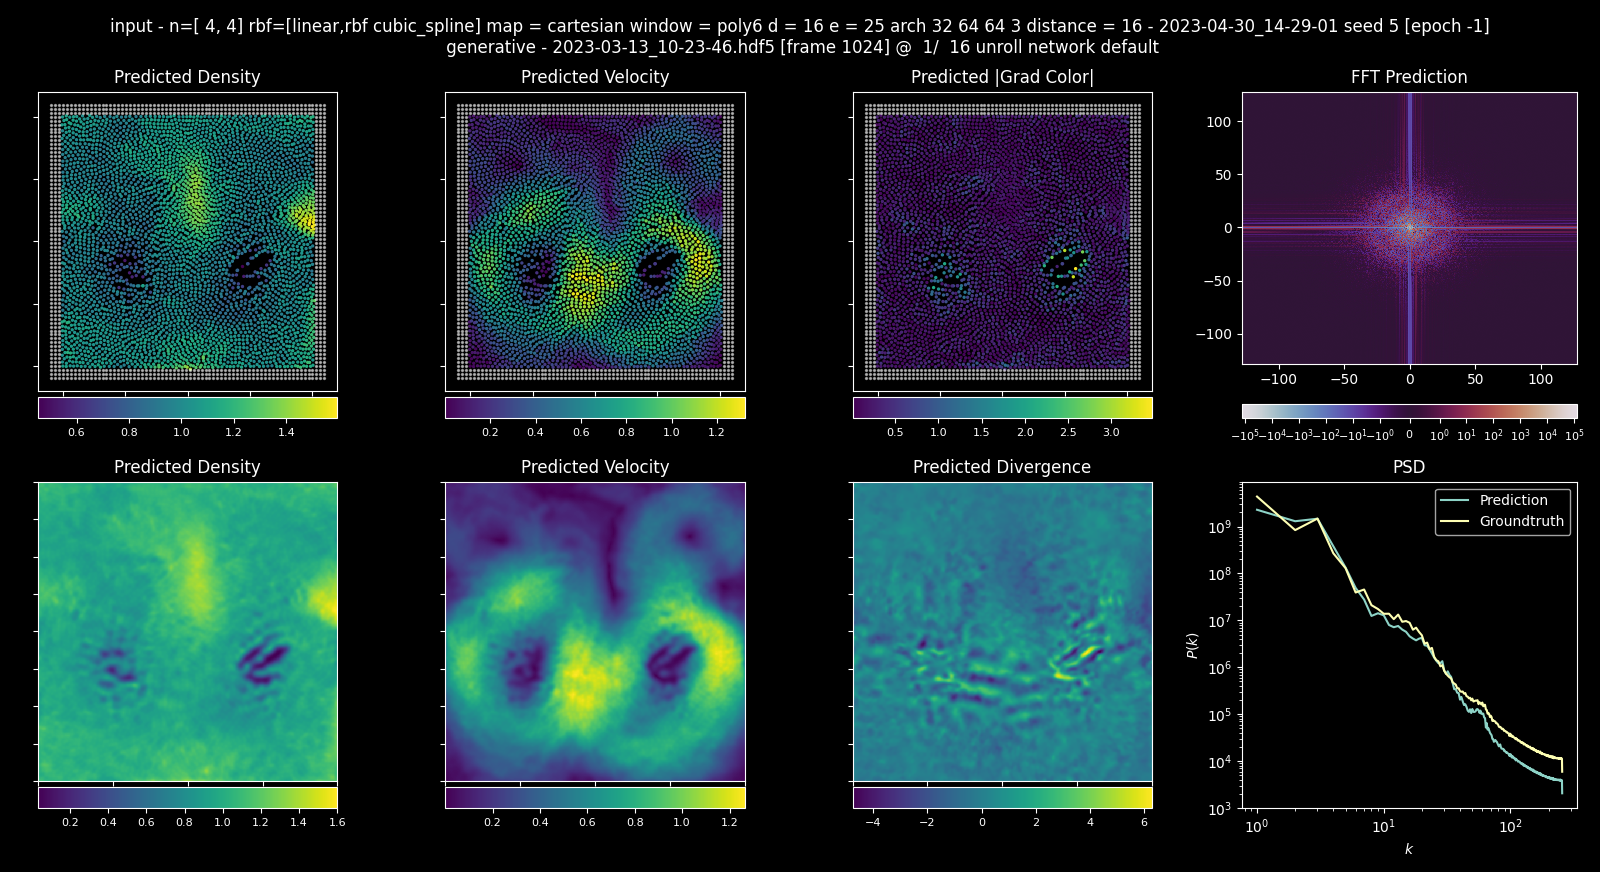

In [26]:
networkIndex = 0
simulationIndex = 0
initialFrame = 1024
unrollSteps = 64
epoch = -1
fig, axis = plt.subplots(2, 4, figsize=(16,8*1.09), sharex = False, sharey = False, squeeze = False)

fig.suptitle('%s [epoch %2d]\n %s [frame %4d] @ %2d/%4d unroll network %s' % (subfolders[networkIndex].split('/')[-1], epoch, simulationFiles[simulationIndex].split('/')[-1], initialFrame, 0 + 1, (0+1) * hyperParams['frameDistance'], hyperParams['network'] if 'network' in hyperParams else 'default'))

scDensity, cbarDensity = scatterPlot(axis[0,0], positions, density, boundaryPositions, 'Predicted Density')
scVelocity, cbarvelocity = scatterPlot(axis[0,1], positions, torch.linalg.norm(velocities,dim=-1), boundaryPositions, 'Predicted Velocity')
scColor, cbarColor = scatterPlot(axis[0,2], positions, torch.linalg.norm(colorGrad,dim=-1), boundaryPositions, 'Predicted |Grad Color|')

imPredDensity, cbarPredDensity = meshPlot(axis[1,0], fp, meshDensity, 'Predicted Density')
# imGTDensity, cbarGTDensity = meshPlot(axis[1,0], fp, gtMeshDensity, 'Groundtruth Density')
imPredVelocity, cbarPredVelocity = meshPlot(axis[1,1], fp, torch.linalg.norm(meshVelocity, dim = -1), 'Predicted Velocity')
# imGTVelocity, cbarGTVelocity = meshPlot(axis[1,1], fp, torch.linalg.norm(gtMeshVelocity, dim = -1), 'Groundtruth Velocity')
imPredDivergence, cbarPredDivergence = meshPlot(axis[1,2], fp, meshDivergence, 'Predicted Divergence')
# imGTDivergence, cbarGTDivergence = meshPlot(axis[1,2], fp, gtMeshDivergence, 'Groundtruth Divergence')
ax = axis[0,3]
ax.set_title('FFT Prediction')
imPredFFT = ax.pcolormesh(ffp[:,0].reshape(data.shape).detach().cpu().numpy(), ffp[:,1].reshape(data.shape).detach().cpu().numpy(), torch.real(fft).detach().cpu().numpy(),
                  norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-torch.max(torch.abs(torch.real(fft))), vmax=torch.max(torch.abs(torch.real(fft))), base=10), cmap = 'twilight')    
ax1_divider = make_axes_locatable(ax)
cax1 = ax1_divider.append_axes("bottom", size="5%", pad="15%")
cbarPredFFT = fig.colorbar(imPredFFT, cax=cax1,orientation='horizontal')
cbarPredFFT.ax.tick_params(labelsize=8) 
axis[1,3].set_title('PSD')
axis[1,3].loglog(kvals, Abins, label = 'Prediction')
axis[1,3].loglog(kvals, gtAbins, label = 'Groundtruth')
axis[1,3].set_xlabel("$k$")
axis[1,3].set_ylabel("$P(k)$")
axis[1,3].legend()
fig.tight_layout()

updatePlot2(fig, axis, positions, density, velocities, colorGrad, meshDensity, gtMeshDensity, meshVelocity, gtMeshVelocity, meshDivergence, gtMeshDivergence, fft, kvals, Abins, gtAbins, scDensity, cbarDensity, imPredDensity, cbarPredDensity, scVelocity, cbarvelocity, imPredVelocity, cbarPredVelocity, imPredDivergence, cbarPredDivergence,imPredFFT, cbarPredFFT,scColor, cbarColor)
